# Tutorial on multinest

This tutorial provides an introduction to the multinest algorithm [1]. This is one of the more advanced algorithms in Pints but is actually not too complex conceptually.

The algorithm is similar to other nested sampling algorithms. Unlike rejection nested sampling and ellipsoidal nested sampling, the domain over which multinest takes place is the unit hypercube $[0,1]^d$, where $d$ is the number of parameters being inferred. Within this domain the samples are assumed to be distributed uniformly. The cumulative density function provides a metric to convert between a uniform distributed sample between 0 and 1 and a sample from the prior (this is the basis of inverse transform sampling and Copulas, for that matter). Assuming an independent prior on parameter dimension $j$,

$$u_j = \int_{-\infty}^{\theta_j} \pi_j(\theta_j') \mathrm{d} \theta_j$$,

so that $\theta_j$ is obtained from $u_j$ using the inverse-cumulative density function of the prior density $\pi(\theta_j)$.

In nested sampling we suppose that we have $N$ active points at each iteration of the algorithm, each existing in $d$-dimensional space, $S = (\boldsymbol{u}_1, \boldsymbol{u}_2,...,\boldsymbol{u}_N)$. Each of these points satisfies $\mathcal{L}(\theta) \geq \mathcal{L}_i$, where $\mathcal{L}_i$ is the minimum likelihood of all points within the active set. These active points - appropriately weighted - form posterior samples. In each iteration, the active particle with the lowest likelihood is dropped from the set and a new particle is drawn uniformly from within the bounding region with a likelihood that exceeds this minimum. The key problem of nested sampling is how to do this step efficiently. A naive way to do this is to sample a new point from the prior and accept it only if $\mathcal{L}(\theta') \geq \mathcal{L}_i$. As the algorithm progresses, however, the area of prior space satisfying this condition shrinks and so this method is impractically inefficient.

Ellipsoidal nested sampling (also in Pints) fits a bounding ellipse to the active points, then draws a new point uniformly from within these bounds. This is not reasonable practice, however, for multimodal posteriors since a bounding ellipse containing points from a number of peaks will necessarily also encompass a low likelihood region.


## How to avoid inefficient sampling?
Multinest aims to avoid this issue by fitting a number of ellipses to bound the active points, from which future proposals are drawn. The size and orientation of the ellipses are chosen to minimise a function,

$$F(S) = \frac{1}{V(S)} \sum_{k=1}^K V(E_k),$$

where $V(S) = exp(-i / N)$ is the expected volume of prior space remaining after iteration $i$ for $N$ active points, and $V(E_k)$ is the volume of bounding ellipsoid $k$. The algorithm given in `Algorithm 1` of [1] provides an E-M algorithm for minimising $F(S)$ subject to the constraint $F(S)\geq 1$ to try to ensure that the space from which we sample contains all prior space with at least a minimum likelihood.

The essence of this algorithm is repeated partitioning of the active particles into subsets $S_k$ whose union is the entire set $S=\bigcup\limits_{i=1}^{k} S_k$. The routine is a type of divide and conquer algorithm where in each part $S_k$ is split into 2 clusters using the k-means algorithm. In essence, these smaller sub-clusters (and their bounding ellipsoids) are accepted as optimal if they improve $F(S)$ substantially. If they do not, then the single larger cluster from which they were generated is used instead. By iterating this process over all clusters, we eventually end up with an optimal number of clusters, whose corresponding ellipsoids likely overlap. By drawing uniformly from within the bounds of the ellipsoids (accounting for the overlap) multinest aims to propose points with sufficient likelihood efficiently.

At the moment, the algorithm as I've coded it does a reasonable job of finding the optimal clusters, although often the clusters overlap considerably more than is stated in the paper. I suspect there is some quirk of my implementation that is causing this issue and I would like to understand why it's not working optimally.

## Sampling from overlapping ellipsoids
The correct way to sample from the bounding ellipsoids to take account of their overlap is to first choose an ellipsoid $E_k$ with probability,

$$p_k = \frac{V(E_k)}{V_{tot}},$$

where $V_{tot} = \sum_{k=1}^K V(E_k)$ is the total volume of the bounding ellipsoids. We then sample uniformly from within $E_k$ until the point drawn has a likelihood which exceeds $\mathcal{L}_i$. We then count the number of ellipsoids in which that point sits, $n_e$, and only accept the sample with probability $1/n_e$.

## Maths appendix
In our implementation of this algorithm, we use the same approximation as that of the paper of the bounding ellipsoid,

$$E_k = \{\boldsymbol{u}\in \mathbb{R}^d | (\boldsymbol{u}-\boldsymbol{\mu}_k)' (f_k \boldsymbol{C}_k)^{-1} (\boldsymbol{u}-\boldsymbol{\mu}_k) \leq 1\},$$

where $\boldsymbol{C}_k$ is the sample covariance matrix and $f_k$ is an `enlargement factor` which is set for each cluster to ensure that the maximally distance point from the cluster mean $\boldsymbol{\mu}_k$ satisfies $(\boldsymbol{u}-\boldsymbol{\mu}_k)' (f_k \boldsymbol{C}_k)^{-1} (\boldsymbol{u}-\boldsymbol{\mu}_k)=1$. We calculate the volume of an ellipsoid by (https://math.stackexchange.com/questions/606184/volume-of-n-dimensional-ellipsoid),

$$V(E) = \frac{\pi^{d/2}}{\Gamma((d/2)+1)} \prod_{i=1}^{d} r_{i}$$,

where $r_i = 1 / \sqrt{\lambda_i}$ are the lengths of the semi axes and $\lambda_i$ are the eigenvalues of the matrix $\boldsymbol{A} = (f_k \boldsymbol{C}_k)^{-1}$.

[1] "MULTINEST: an efficient and robust Bayesian inference tool for cosmology and particle physics", Mon. Not. R. Astron. Soc., 2008, F. Feroz, M.P. Hobson and M. Bridges.

In [1]:
import numpy as np
import numpy.linalg as la
from scipy.misc import logsumexp
import scipy.special
def minimum_volume_ellipsoid(points, tol=0.001):
        """
        Finds the ellipse equation in "center form":
        ``(x-c).T * A * (x-c) = 1``.
        """
        N, d = points.shape
        Q = np.column_stack((points, np.ones(N))).T
        err = tol + 1
        u = np.ones(N) / N
        while err > tol:
            # assert(u.sum() == 1) # invariant
            X = np.dot(np.dot(Q, np.diag(u)), Q.T)
            M = np.diag(np.dot(np.dot(Q.T, la.inv(X)), Q))
            jdx = np.argmax(M)
            step_size = (M[jdx] - d - 1) / ((d + 1) * (M[jdx] - 1))
            new_u = (1 - step_size) * u
            new_u[jdx] += step_size
            err = la.norm(new_u - u)
            u = new_u
        c = np.dot(u, points)
        A = la.inv(
            + np.dot(np.dot(points.T, np.diag(u)), points)
            - np.multiply.outer(c, c)
        ) / d
        return A, c

def plot_ellipse(A, c, u):
    """
    Plots a ellipse equation in "center form":
    ``(x-c).T * A * (x-c) = 1``.
    """
    A = np.linalg.inv(A)
    evs, evecs = np.linalg.eig(A)
    evs = np.sqrt(evs)
    a = evs[0]
    b = evs[1]
    x0 = c[0]
    y0 = c[1]
    alpha = np.arctan(evecs[:, 0][1] / evecs[:, 0][0])
    theta = np.linspace(0, 2 * np.pi, 1000)

    x = x0 + a * np.cos(theta) * np.cos(alpha) - b * np.sin(theta) * np.sin(alpha)
    y = y0 + a * np.cos(theta) * np.sin(alpha) + b * np.sin(theta) * np.cos(alpha)
    plt.plot(x, y)
    plt.scatter(u[:, 0], u[:, 1], c='k')
    plt.show()

def ellipse_volume_calculator(A):
    d = A.shape[0]
    r = np.sqrt(1 / np.linalg.eigvals(A))
    return (np.pi**(d / 2.0) / scipy.special.gamma((d / 2.0) + 1)) * np.prod(r)

def enlarge_ellipse_A(enlargement_factor, A):
    return (1 / enlargement_factor) * A

def V_S_calculator(i, N):
    return np.exp(-i / N)

# algorithm 1 various steps
def step_1(u):
    A, c = minimum_volume_ellipsoid_fast(u)
    V_E = ellipse_volume_calculator(A)
    return A, c, V_E

def comparison_enlargement(V_S, V_E, A):
    if V_E > V_S:
        return A
    else:
        enlargement_factor = V_S / V_E
        return enlarge_ellipse_A(enlargement_factor, A)

def step_2(i, N, V_E, A):
    V_S = V_S_calculator(i, N)
    return comparison_enlargement(V_S, V_E, A), V_S

from scipy.cluster.vq import vq, kmeans
def step_3(u):
    centers, assignment = scipy.cluster.vq.kmeans2(u, 2, minit="points")
    while sum(assignment==0) < 3 or sum(assignment==1) < 3:
        centers, assignment = scipy.cluster.vq.kmeans2(u, 2, minit="points")
    return centers, assignment
def ellipse_find_volume_calculator(a_index, u, assigments):
    points = u[np.where(assignment == a_index)]
    A, c = minimum_volume_ellipsoid(points)
    return A, c, ellipse_volume_calculator(A)
def ellipse_find_volume_calculator_fast(a_index, u, assignments, tol=0):
    points = u[np.where(assignments == a_index)]
    A, c = minimum_volume_ellipsoid_fast(points, tol)
    return A, c, ellipse_volume_calculator(A)
def step_4(assignments, u):
    A_l = [None] * 2
    c_l = [None] * 2
    V_E_l = [None] * 2
    for i in range(0, 2):
        A, c, V_E = ellipse_find_volume_calculator_fast(i, u, assignments)
        A_l[i] = A
        c_l[i] = c
        V_E_l[i] = V_E
    return A_l, c_l, V_E_l
def V_S_k_calculator(n_k, N, V_S):
    return n_k * V_S / N
def step_5(assignments, V_E_l, A_l, V_S):
    A_new_l = [None] * 2
    V_S_k_l = [None] * 2
    V_E_k_l = [None] * 2
    N = len(assignments)
    for i in range(0, 2):
        n = np.sum(assignments == i)
        V_S_k_l[i] = V_S_k_calculator(n, N, V_S)
        A_new_l[i] = comparison_enlargement(V_S_k_l[i], V_E_l[i], A_l[i])
        V_E_k_l[i] = ellipse_volume_calculator(A_new_l[i])
    return A_new_l, V_S_k_l, V_E_k_l
def mahalanobis_distance(point, mean, A):
    return np.matmul(np.matmul(point - mean, A), point - mean)
# Based on eqn. (16) in the paper but corrected for subtracting the means
# also added a tolerance that can be used to improve performance
def minimum_volume_ellipsoid_fast(points, tol=0.0):
    cov = np.cov(np.transpose(points))
    cov_inv = np.linalg.inv(cov)
    c = np.mean(points, axis=0)
    dist = np.zeros(len(points))
    for i in range(len(points)):
        dist[i] = mahalanobis_distance(points[i], c, cov_inv)
    enlargement_factor = np.max(dist)
    A = (1 - tol) * (1.0 / enlargement_factor) * cov_inv
    return A, c

def step_6(points, c_k_l, A_k_l, V_E_l, V_S_k_l):
    n = len(points)
    assignments_new = np.zeros(n)
    for i in range(0, n):
        h_k_max = float('inf')
        for j in range(0, 2):
            h_k = h_k_calculator(points[i], c_k_l[j],
                                 A_k_l[j], V_E_l[j], V_S_k_l[j])
            if h_k < h_k_max:
                assignments_new[i] = j
                h_k_max = h_k
    return assignments_new
def h_k_calculator(point, mean_k, A_k, V_E_k, V_S_k):
    d = mahalanobis_distance(point, mean_k, A_k)
    return V_E_k * d / V_S_k
def plot_ellipse_basic(A, c):
    """
    Plots a ellipse equation in "center form":
    ``(x-c).T * A * (x-c) = 1``.
    """
    A = np.linalg.inv(A)
    evs, evecs = np.linalg.eig(A)
    evs = np.sqrt(evs)
    a = evs[0]
    b = evs[1]
    x0 = c[0]
    y0 = c[1]
    alpha = np.arctan(evecs[:, 0][1] / evecs[:, 0][0])
    theta = np.linspace(0, 2 * np.pi, 1000)

    x = x0 + a * np.cos(theta) * np.cos(alpha) - b * np.sin(theta) * np.sin(alpha)
    y = y0 + a * np.cos(theta) * np.sin(alpha) + b * np.sin(theta) * np.cos(alpha)
    plt.plot(x, y)
def plot_many_ellipse(A_l, c_l, u):
    for i in range(0, len(A_l)):
        plot_ellipse_basic(A_l[i], c_l[i])
    plt.scatter(u[:, 0], u[:, 1], c='k')
    plt.show()
def plot_many_ellipse_basic(A_l, c_l):
    for i in range(0, len(A_l)):
        plot_ellipse_basic(A_l[i], c_l[i])
    
def draw_from_ellipsoid(covmat, cent, npts):
        """
        Draw `npts` random uniform points from within an ellipsoid with a
        covariance matrix covmat and a centroid cent, as per:
        http://www.astro.gla.ac.uk/~matthew/blog/?p=368
        """
        try:
            ndims = covmat.shape[0]
        except IndexError:  # pragma: no cover
            ndims = 1

        # calculate eigen_values (e) and eigen_vectors (v)
        eigen_values, eigen_vectors = la.eig(covmat)
        idx = (-eigen_values).argsort()[::-1][:ndims]
        e = eigen_values[idx]
        v = eigen_vectors[:, idx]
        e = np.diag(e)

        # generate radii of hyperspheres
        rs = np.random.uniform(0, 1, npts)

        # generate points
        pt = np.random.normal(0, 1, [npts, ndims])

        # get scalings for each point onto the surface of a unit hypersphere
        fac = np.sum(pt**2, axis=1)

        # calculate scaling for each point to be within the unit hypersphere
        # with radii rs
        fac = (rs**(1 / ndims)) / np.sqrt(fac)
        pnts = np.zeros((npts, ndims))

        # scale points to the ellipsoid using the eigen_values and rotate with
        # the eigen_vectors and add centroid
        d = np.sqrt(np.diag(e))
        d.shape = (ndims, 1)

        for i in range(0, npts):
            # scale points to a uniform distribution within unit hypersphere
            pnts[i, :] = fac[i] * pt[i, :]
            pnts[i, :] = np.dot(
                np.multiply(pnts[i, :], np.transpose(d)),
                np.transpose(v)
            ) + cent

        return pnts
def f_s_minimisation_steps_1_to_3(i, u):
    A, c, V_E = step_1(u)
    N = len(u)
    A, V_S = step_2(i, N, V_E, A)
    V_E = ellipse_volume_calculator(A)
    centers, assignments = step_3(u)
    return assignments, A, N, V_E, V_S, c
def f_s_minimisation_lines_4_to_13(assignments, u, V_S, max_recursion):
    A_k_l, c_k_l, V_E_l = step_4(assignments, u)
    A_new_l, V_S_k_l, V_E_k_l = step_5(assignments, V_E_l, A_k_l, V_S)
    assignments_new = step_6(u, c_k_l, A_k_l, V_E_k_l, V_S_k_l)
    assignments_new = assignments_new.astype(int)
    # stops algorithmic oscillation (not in original algorithm)
    if sum(assignments_new==0) < 3 or sum(assignments_new==1) < 3:
        return assignments, A_k_l, V_S_k_l, c_k_l, V_E_k_l
    if max_recursion > 10:
        return assignments_new, A_new_l, V_S_k_l, c_k_l, V_E_k_l
    if np.array_equal(assignments, assignments_new):
        return assignments_new, A_new_l, V_S_k_l, c_k_l, V_E_k_l
    else:
        return f_s_minimisation_lines_4_to_13(assignments_new, u, V_S, max_recursion + 1)
def f_s_minimisation_lines_2_onwards(u, V_E, V_S, A, c, A_l_running, c_l_running):
    A = comparison_enlargement(V_S, V_E, A)
    V_E = ellipse_volume_calculator(A)
    centers, assignments = step_3(u)
    assignments_new, A_new_l, V_S_k_l, c_k_l, V_E_k_l = f_s_minimisation_lines_4_to_13(assignments, u, V_S, 1)
    # lines 14 onwards
    V_E_k_tot = np.sum(V_E_k_l)
    if V_E_k_tot < V_E or V_E > 2 * V_S:
        for i in range(0, 2):
            u_new = u[np.where(assignments_new == i)]
            # added this line to prevent too small clusters
            if len(u_new) < 50:
                A_l_running.append(A)
                c_l_running.append(c)
                return A_l_running, c_l_running
            A_l_running, c_l_running = f_s_minimisation_lines_2_onwards(u_new, V_E_k_l[i], V_S_k_l[i], A_new_l[i], c_k_l[i], A_l_running, c_l_running)
        return A_l_running, c_l_running
    else:
        A_l_running.append(A)
        c_l_running.append(c)
        return A_l_running, c_l_running
def f_s_minimisation(iteration, u):
    assignments, A, N, V_E, V_S, c = f_s_minimisation_steps_1_to_3(iteration, u)
    assignments_new, A_new_l, V_S_k_l, c_k_l, V_E_k_l = f_s_minimisation_lines_4_to_13(assignments, u, V_S, 1)
    # lines 14 onwards
    A_l_running = []
    c_l_running = []
    V_E_k_tot = np.sum(V_E_k_l)
    if V_E_k_tot < V_E or V_E > 2 * V_S:
        for i in range(0, 2):
            u_new = u[np.where(assignments_new == i)]
            A_l_running, c_l_running = f_s_minimisation_lines_2_onwards(u_new, V_E_k_l[i], V_S_k_l[i], A_new_l[i], c_k_l[i], A_l_running, c_l_running)
        V_E_k_l1 = []
        for j in range(0, len(A_l_running)):
            V_E_k_l1.append(ellipse_volume_calculator(A_l_running[j]))
        return A_l_running, c_l_running, np.sum(V_E_k_l1) / V_S
    else:
        return [A], [c], V_E / V_S

    # determines the number of ellipses a point x lies within
def count_ellipses(x, A_l, c_l):
    n_e = 0
    for i in range(len(A_l)):
        if mahalanobis_distance(x, c_l[i],A_l[i]) <= 1:
            n_e += 1
    return n_e

## Generate 2d points uniformly (in multinest the points must be uniformly distributed in parameter space)

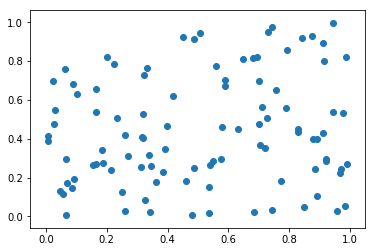

In [2]:
import matplotlib.pyplot as plt
N = 100
u = np.random.uniform(0, 1, size=(N, 2))
plt.scatter(u[:, 0], u[:, 1])
plt.show()

## Calculate minimum volume ellipsoid and plot it

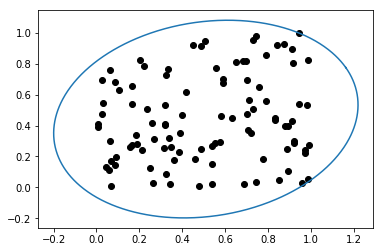

1.40845690039


In [3]:
A, c = minimum_volume_ellipsoid_fast(u)
plot_ellipse(A, c, u)
print(ellipse_volume_calculator(A))

## Applying F_s minimisation to points

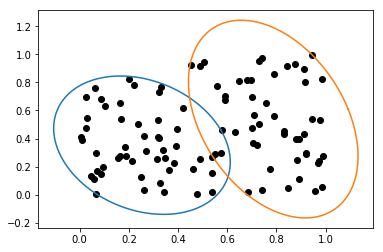

In [4]:
A, c, F_S = f_s_minimisation(1, u)
plot_many_ellipse(A, c, u)

## How do we do versus the paper?
Now demonstrate algorithm working in 2d as in Fig. 3 of the multinest paper. A value of $F_S=1.1$ is given in the paper for 1000 points drawn from similar numbers of clusters. Since the generation of the points and the fitting of the ellipsoids is stochastic, we need to do a number of trials before we obtain similar outputs to the paper.

Note the bottom takes a few minutes to run.

In [5]:
trials = 100
i = 1400
n = 500
A_1 = np.array([[0.2, 0.03], [0.03, 0.02]])
A_2 = np.array([[0.1, -0.03], [-0.03, 0.01]])
F_S_min = 1000

for j in range(trials):
    p1 = draw_from_ellipsoid(A_1, [0.5, 0.25], 800)
    p2 = draw_from_ellipsoid(A_2, [0.5, 0.75], 200)
    u = np.concatenate((p1, p2))
    A, c, F_S = f_s_minimisation(i, u)
    if F_S < F_S_min:
        F_S_min = F_S
        A_min = A
        c_min = c
        u_min=u

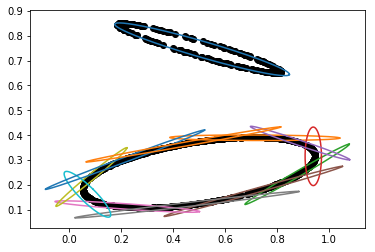

1.0600231308787782

In [6]:
plot_many_ellipse(A_min, c_min, u_min)
F_S_min

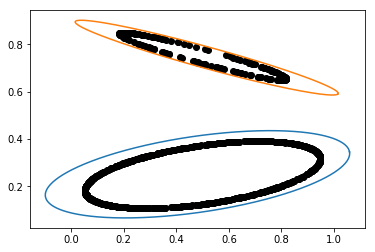

In [4]:
import matplotlib.pyplot as plt
i = 1
A_1 = np.array([[0.2, 0.03], [0.03, 0.02]])
A_2 = np.array([[0.1, -0.03], [-0.03, 0.01]])
p1 = draw_from_ellipsoid(A_1, [0.5, 0.25], 800)
p2 = draw_from_ellipsoid(A_2, [0.5, 0.75], 200)
u = np.concatenate((p1, p2))
A, c, F_S = f_s_minimisation(i, u)
plot_many_ellipse(A, c, u)

# Draw points from a Torus

Use PINTS' annulus function to draw points from the 2d annulus then use MultiNest's ellipsoidal minimiser to fit optimal number of ellipses to the points.

Note the bottom takes a few minutes to run.

In [7]:
import os
os.chdir("../")
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# try many times to find F_S
trials = 100
F_S_min = 1000
N = 1000
i = 1000

for j in range(trials):
    radius = 10
    d = 0.5
    reduction_factor = 25
    model = pints.toy.AnnulusLogPDF(2, r0=radius, sigma=d)
    radius = radius / reduction_factor
    d = d / reduction_factor
    u = model.sample(N) / reduction_factor + 0.5
    A, c, F_S = f_s_minimisation(i, u)
    if F_S < F_S_min:
        F_S_min = F_S
        A_min = A
        c_min = c
        u_min=u
    V_S = np.exp(-i / N)
    approx_vol = np.pi * ((radius+d)**2 - (radius-d)**2)
    a_vol = map(lambda x: ellipse_volume_calculator(x), A)

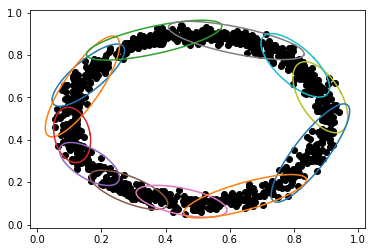

1.16505166644


In [9]:
plot_many_ellipse(A_min, c_min, u_min)
print(F_S_min)

## Test function which determines number of ellipses bounding a given point

In [10]:
print(count_ellipses([0.5, 0.25], A, c))
print(count_ellipses([0.5, 0.6], A, c))

1
1


## Draw uniformly from within the 1st ellipse

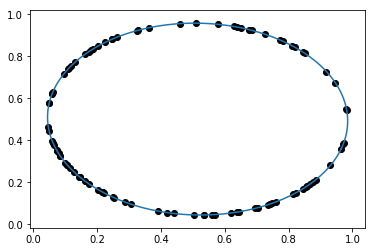

In [11]:
samples = draw_from_ellipsoid(np.linalg.inv(A[0]), c[0], 100)
plot_ellipse(A[0], c[0], samples)

## Draw a sample and count number of number of bounding ellipses

In [12]:
def draw_from_ellipsoid_count(A, c, A_l, c_l):
    x = draw_from_ellipsoid(np.linalg.inv(A), c, 1)[0]
    return x, count_ellipses(x, A_l, c_l)

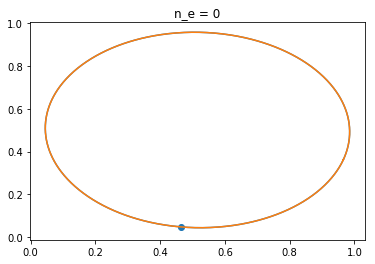

In [13]:
x, n_e = draw_from_ellipsoid_count(A[0], c[0], A, c)
plot_ellipse_basic(A[0], c[0])
plt.scatter(x[0], x[1])
plot_many_ellipse_basic(A, c)
plt.title('n_e = ' + str(n_e))
plt.show()